# Exploration phase (**optional**)

In this exploration phase we will visualize some features of your dataset to help you make more informed decisitions in case you want to **adapt the default parameters** to your dataset.

You can always skip this part and go with the default parameters but if you want to have a classifier as efficient as possible you should consider spending five minutes running this analysis.

## 1.1 Distribution of classes
**Relevant parameters:** `use_class_weights`

We can visualize the distributions of the classes to check is the dataset is highly imbalanced.

In [ ]:

import os

import matplotlib.pylab as plt
import numpy as np
from tqdm import tqdm

import planktonclas
from planktonclas import paths, config
from planktonclas.data_utils import load_image, load_data_splits, augment, load_class_names


CONF = config.get_conf_dict()

# Customize your image folder if needed
# CONF['general']['images_directory'] = '/media/ignacio/Datos/datasets/semillas/datasets'  # absolute path to image_folder

splits_dir = paths.get_splits_dir()

# Load the training data
X_train, y_train = load_data_splits(splits_dir=splits_dir,
                                    im_dir=CONF['general']['images_directory'],
                                    split_name='train')

# Load the validation data
if (CONF['training']['use_validation']) and ('val.txt' in os.listdir(splits_dir)):
    X_val, y_val = load_data_splits(splits_dir=splits_dir,
                                    im_dir=CONF['general']['images_directory'],
                                    split_name='val')
else:
    print('No validation data.')
    X_val, y_val = None, None
    CONF['training']['use_validation'] = False
    
# Load the class names
class_names = load_class_names(splits_dir=splits_dir)

Max Training: 8060.0
Min Training: 9.0
Mean Training: 2529.0102040816328
Median Training: 689.5


Max Validation: 1054.0
Min Validation: 1.0
Mean Validation: 316.1326530612245
Median Validation: 91.0




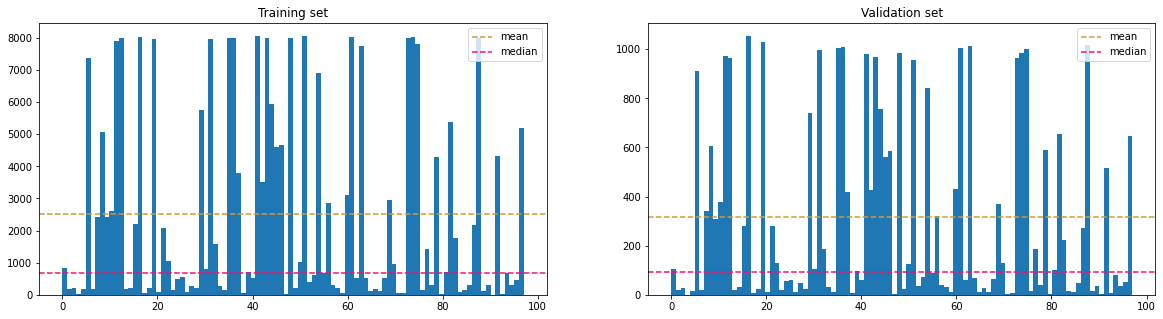

In [20]:
# Define some parameters
log_scale = False
show_names = False

# Plot the histograms
fig, axs = plt.subplots(1, 2, figsize=(20,5))

def plot_hist(ax, y, set_name=''):
    n, bins, patches = ax.hist(y, bins=len(class_names), log=log_scale)
    mean, med = np.mean(n), np.median(n)
    ax.axhline(mean, linestyle= '--', color='#ce9b3b', label='mean')
    ax.axhline(med, linestyle= '--', color='#fc0c70', label='median')
    ax.set_title('{} set'.format(set_name))
    ax.legend()
    if show_names:
        ax.set_xticks(range(len(class_names)))
        ax.set_xticklabels(class_names, rotation='vertical')

    print('Max {}: {}'.format(set_name, np.amax(n)))
    print('Min {}: {}'.format(set_name, np.amin(n)))
    print('Mean {}: {}'.format(set_name, mean))
    print('Median {}: {}'.format(set_name, med))
    print('\n')

plot_hist(axs[0], y_train, set_name='Training')

axs[1].set_title('Validation set')
if y_val is not None:
    plot_hist(axs[1], y_val, set_name='Validation')

So if your dataset is **very** imbalanced you can consider setting the `use_class_weights` to `True` to compensate for this imbalance during the training.

## 1.2 Distribution of image sizes
**Relevant parameters:** `im_size`

We can visualize how the sizes of your images are tipically distributed in case you want to use a bigger image size resolution than the default.

In [56]:
# Load all images and retrieve their shapes
height, width = [], []
for img_path in tqdm(X_train):
    img = load_image(img_path)
    w, h, channels = img.shape
    width.append(w)
    height.append(h)

100%|██████████| 246249/246249 [29:24<00:00, 139.58it/s]


Max Heights: 987
Min Heights: 9
Mean Heights: 83.7
Median Heights: 70.0
Heights 5th percentile: 25.0


Max Widths: 964
Min Widths: 11
Mean Widths: 107.7
Median Widths: 87.0
Widths 5th percentile: 47.0


Max Combined: 987
Min Combined: 9
Mean Combined: 95.7
Median Combined: 78.0
Combined 5th percentile: 32.0




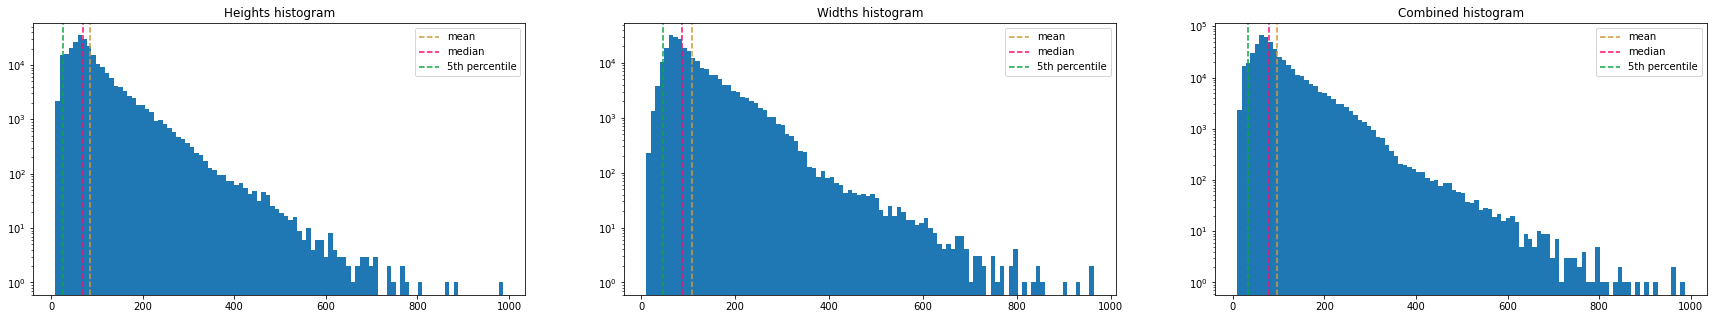

In [57]:
# Define some parameters
bins = 100
log_scale = True
lower_percentile = 5

def plot_hist(ax, values, set_name=''):
    
    # Print some stats
    mean, med, per = np.mean(values), np.median(values), np.percentile(values, lower_percentile)

    print('Max {}: {}'.format(set_name, np.amax(values)))
    print('Min {}: {}'.format(set_name, np.amin(values)))
    print('Mean {}: {:.1f}'.format(set_name, mean))
    print('Median {}: {}'.format(set_name, med))
    print('{} {}th percentile: {}'.format(set_name, lower_percentile, per))
    print('\n')
      
    # Plot the histogram
    ax.hist(values, bins=bins, log=log_scale)
    ax.set_title('{} histogram'.format(set_name))
    ax.axvline(mean, linestyle= '--', color='#ce9b3b', label='mean')
    ax.axvline(med, linestyle= '--', color='#fc0c70', label='median')
    ax.axvline(per, linestyle= '--', color='#0ea541', label='{}th percentile'.format(lower_percentile))
    ax.legend()

    
fig, axs = plt.subplots(1, 3, figsize=(30,5))
axs = axs.flatten()

plot_hist(axs[0], height, set_name='Heights')
plot_hist(axs[1], width, set_name='Widths')
plot_hist(axs[2], height + width, set_name='Combined')

So after examining these plots and stats you can consider adapting the parameter `im_size` to better suit your usecase (maybe to a value in between the `Min combined` and the `Combined 5th percentile`).

When **increasing** this parameter from the default value you have to consider that:
* you keep more details in the image so the accuracy of the model *might* (or might not) increase.
* bigger images size means longer training and inference times
* bigger images means more model parameters. So it is possible to that model becomes too big to be trained on a GPU. 